## Propagation of deformable mirror coupled speckle at the output of the fiber

A Step-Index fiber is used

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.datasets import SimulatedStepIndexSpeckleOutputDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions

In [27]:
def numerical_aperture_to_n2(NA: float, n1: float) -> float:
    return np.sqrt(np.square(n1) - np.square(NA))

### Setup

Set the computation grid and the fiber characteristics

In [152]:
fiber_settings: dict = {'radius': 25e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'NA': 0.22}
fiber_settings['n2'] = numerical_aperture_to_n2(NA=fiber_settings['NA'], n1=fiber_settings['n1'])
fiber_settings.pop('NA')

fiber_type: str = 'step'
grid_settings: dict = {'pixel_size': 0.7e-6, 'pixel_numbers': (128, 128)}
dataset_settings: dict = {'length': 500, 'degen': True, 'phases_dim': (12,12)}
fourier_settings: dict = {'pad': 1}
export_settings: dict = {'return_output_fields': True, 'add_exp_noise': False, 'noise_func': np.max, 'file_type': 'matlab'}

### Dataset generation

Generate the grid and the fiber

In [153]:
grid = Grid(**grid_settings)

if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

c:\users\jysru\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))
c:\users\jysru\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.465
  - Cladding index: 1.4483870339104807
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.220
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46491477  0.          0.          1.        ]
 [ 1.46478363  2.          1.          1.        ]
 [ 1.46461132  4.          2.          1.        ]
 [ 1.46455097  1.          0.          2.        ]
 [ 1.46440012  6.          3.          1.        ]
 [ 1.46427476  3.          1.          2.        ]
 [ 1.46415142  8.          4.          1.        ]
 [ 1.46395609  5.          2.          2.        ]
 [ 1.46389666  2.          0.          3.        ]
 [ 1.46386618 10.          5.          1.        ]]


Compute and store the modes for a much faster dataset generation, plot one for checking extent

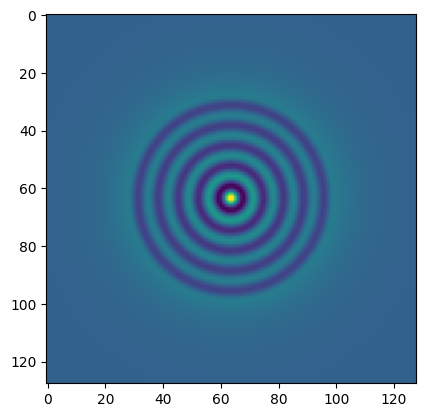

In [154]:
fiber.compute_modes_fields(grid)
plt.imshow(fiber._modes[:,:,1,-1])

Compute dataset

In [155]:
dset = SimulatedStepIndexSpeckleOutputDataset(fiber, grid, N_modes=fiber._N_modes_degen, length=dataset_settings['length'])
dset.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])

Found 12 input variable weights below threshold 0.001 to delete.
Successfully deleted low weight input variables.
Computed TM row 1/132
Computed TM row 2/132
Computed TM row 3/132
Computed TM row 4/132
Computed TM row 5/132
Computed TM row 6/132
Computed TM row 7/132
Computed TM row 8/132
Computed TM row 9/132
Computed TM row 10/132
Computed TM row 11/132
Computed TM row 12/132
Computed TM row 13/132
Computed TM row 14/132
Computed TM row 15/132
Computed TM row 16/132
Computed TM row 17/132
Computed TM row 18/132
Computed TM row 19/132
Computed TM row 20/132
Computed TM row 21/132
Computed TM row 22/132
Computed TM row 23/132
Computed TM row 24/132
Computed TM row 25/132
Computed TM row 26/132
Computed TM row 27/132
Computed TM row 28/132
Computed TM row 29/132
Computed TM row 30/132
Computed TM row 31/132
Computed TM row 32/132
Computed TM row 33/132
Computed TM row 34/132
Computed TM row 35/132
Computed TM row 36/132
Computed TM row 37/132
Computed TM row 38/132
Computed TM row 39/13

### Dataset checking
Display a random draw from the dataset as a check

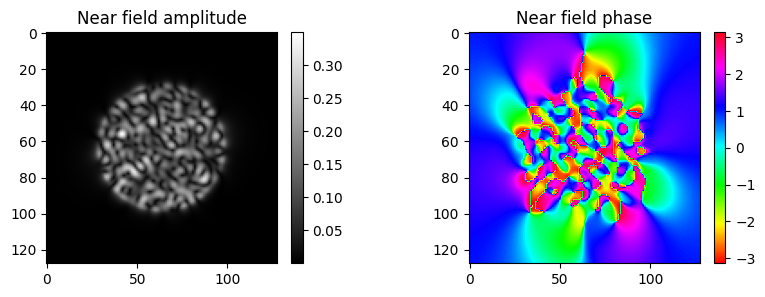

In [156]:
def plot_complex_field(field: np.ndarray) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    pl0 = axs[0].imshow(np.abs(field), cmap='gray')
    pl1 = axs[1].imshow(np.angle(field), cmap='hsv')
    plt.colorbar(pl0, ax=axs[0], fraction=0.046, pad=0.04)
    plt.colorbar(pl1, ax=axs[1], fraction=0.046, pad=0.04)
    axs[0].set_title('Near field amplitude')
    axs[1].set_title('Near field phase')

rand_idx = np.random.randint(0, dset._fields.shape[-1])
plot_complex_field(dset._fields[..., rand_idx])

### Propagation

Define functions

In [157]:
def fourier_transform(field):
    ft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(field, axes=(0,1)), axes=(0,1)), axes=(0,1))
    ft = ft / np.sqrt(ft.size)
    return ft

def get_fresnel_prop(field, delta_z: float, wavelength: float = 1064e-9, pixel_size = grid_settings['pixel_size']):
    extent = field.shape[0] * pixel_size
    dNxy = 1/(extent) # Size of a sample in the Fourier plane [1/m]
    limNxy = (field.shape[0] / 2) * dNxy ; # Interval boundaries [1/m]
    kx = 2 * np.pi * np.arange(start= -limNxy, stop=limNxy, step=dNxy) # Angular frequencies vector (x-axis) [rad/m]
    KX, KY = np.meshgrid(kx, kx)
    propagator = np.exp(1j * delta_z * np.sqrt(np.abs(4 * np.square(np.pi / wavelength) - np.square(KX) - np.square(KY))))
    return np.expand_dims(propagator, -1) if field.ndim >= 3 else propagator

def fresnel_transform(field, propagator):
    ft = np.fft.fftshift(np.fft.fft2(field, axes=(0,1)), axes=(0,1))
    ft = ft * propagator
    ift = np.fft.ifft2(np.fft.ifftshift(ft, axes=(0,1)), axes=(0,1))
    return ift

def get_average_intensity(fields):
    return np.mean(np.square(np.abs(fields)), axis=-1)

In [158]:
pad_amount = 64
fields = np.pad(dset._fields, [(pad_amount,pad_amount), (pad_amount,pad_amount), (0,0)])
print(fields.shape)

(256, 256, 500)


In [159]:
z = np.arange(0, 350e-6, 25e-6)
props = [get_fresnel_prop(fields[..., 0:10], dz) for dz in z]

In [160]:
frts = []
avg_intens = []
for i in range(len(z)):
    frts.append(fresnel_transform(fields[..., 0:500], props[i]))
    avg_intens.append(get_average_intensity(frts[i]))

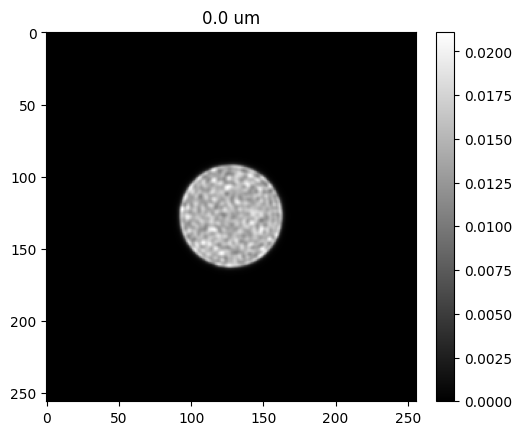

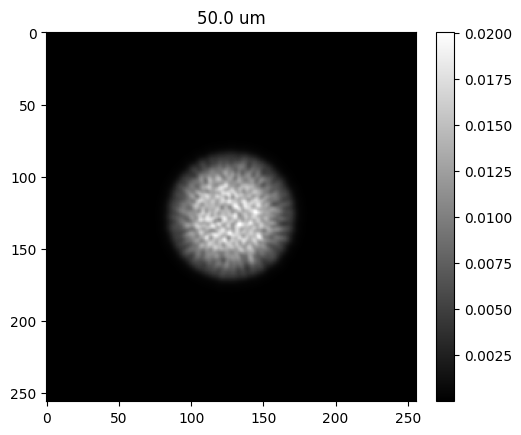

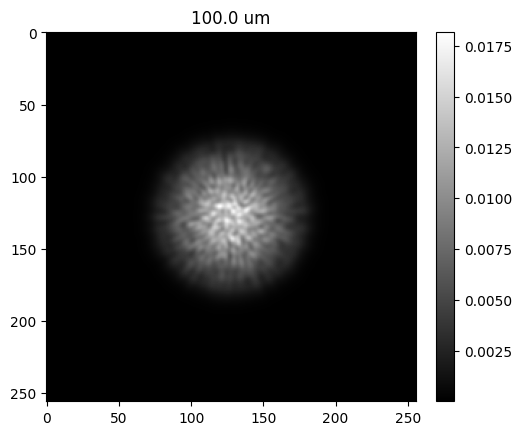

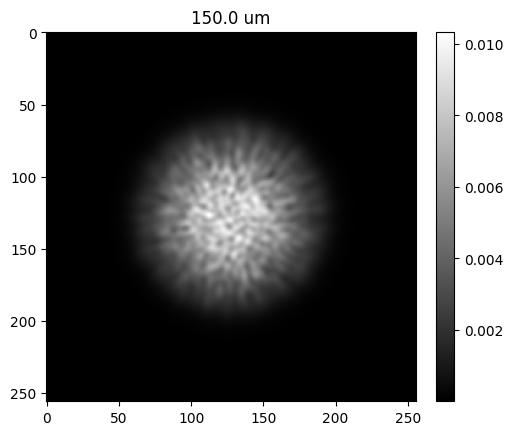

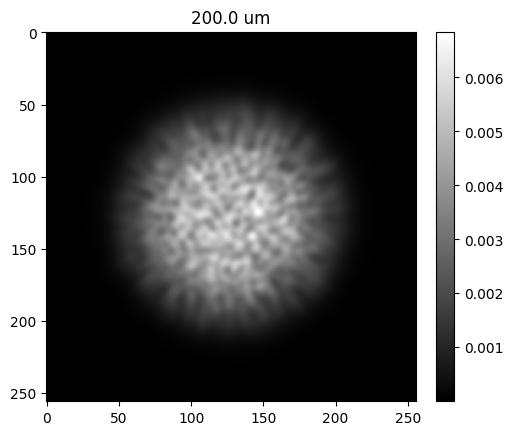

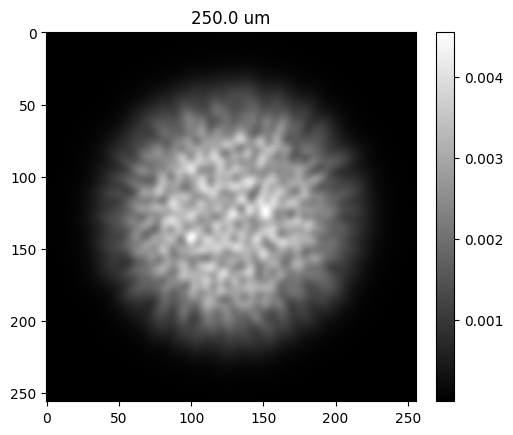

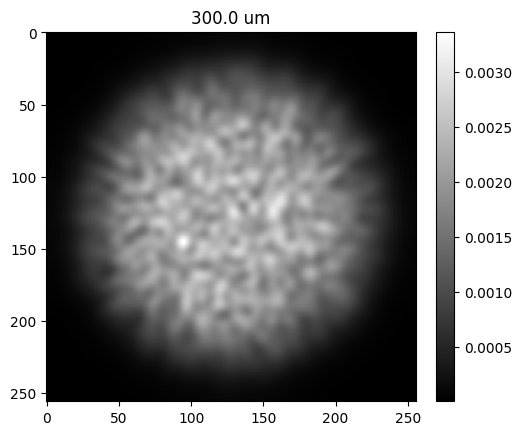

In [161]:
for i in range(len(z)):
    intens = avg_intens[i]

    if i % 2 == 0:
        plt.imshow(intens, cmap='gray')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"{z[i]*1e6} um")
        plt.show()

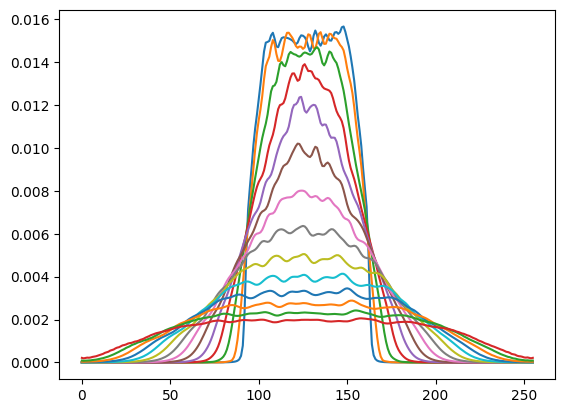

In [165]:
bound = 100
crosscuts = []
for i in range(len(z)):
    cut_x = np.mean(avg_intens[i][bound:-bound, :], axis=0)
    cut_y = np.mean(avg_intens[i][:, bound:-bound], axis=1)
    crosscuts.append((cut_x + cut_y) / 2)
crosscuts = np.array(crosscuts)

plt.plot(np.transpose(crosscuts))

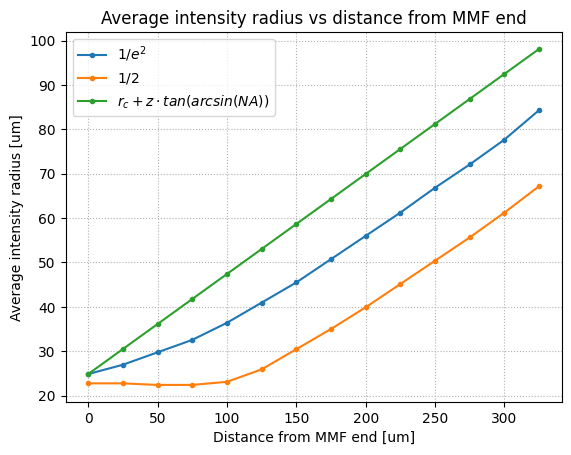

In [192]:
def get_width(crosscut, cutoff: float = 1 / np.exp(2)) -> float:
    length = crosscut.size
    crosscut /= np.max(crosscut)
    idx_left = np.argmin(np.abs(crosscut[:length//2] - cutoff))
    idx_right = length//2 + np.argmin(np.abs(crosscut[length//2:] - cutoff))
    return np.abs(idx_right - idx_left)


widths_1e2 = []
widths_half = []
for i in range(len(z)):
    widths_1e2.append(get_width(crosscuts[i, :], 1 / np.exp(2)) * grid.pixel_size)
    widths_half.append(get_width(crosscuts[i, :], 1 / 2) * grid.pixel_size)

theta = np.arcsin(fiber._NA)

plt.grid('on', ls=':')
plt.plot(z * 1e6, np.array(widths_1e2) / 2 * 1e6, marker='.', label=r"$1 / e^{2}$")
plt.plot(z * 1e6, np.array(widths_half) / 2 * 1e6, marker='.', label=r"$1 / 2$")
plt.plot(z * 1e6, (np.array(widths_1e2)[0] / 2 + np.tan(theta) * z) * 1e6, marker='.', label=r"$r_{c} + z \cdot tan(arcsin(NA))$")
plt.xlabel('Distance from MMF end [um]')
plt.ylabel('Average intensity radius [um]')
plt.title("Average intensity radius vs distance from MMF end")
plt.legend()
